# Biol 359A  | Data as matrices, ANOVA
### Spring 2022, Week 3
<hr>

Objectives:
-  Understand the structure of data
-  Gain intuition about ANOVA
-  Read some more basic python syntax

Updates from last classwork:
-  Now that you have had time to familiarize yourselves with the interface, we will be grading some components on accuracy rather than engagement! 

# W2 Quiz Review

In [ ]:
!git clone https://github.com/BIOL359A-FoundationsOfQBio-Spr22/week3_anova
!mkdir ./data
!cp week3_anova/data/* ./data
!cp week3_anova/clean_data.py ./

In [24]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import ttest_ind as ttest

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import qqplot

TITLE_FONT = 20
LABEL_FONT = 16
TICK_FONT = 16
FIG_SIZE = (12,12)

sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set(font_scale=1.5) #Change from 1 to 1.5 or 2 if you have a hard time reading text

# Question 2: Sample size and Power



In [82]:
def run_experiment(effect_size = 0.1, n=1000):
    mu_A = 0
    sigma = 2
    
    mu_B = sigma*effect_size+mu_A
    A = [random.gauss(mu_A, sigma) for _ in range(n)]
    B = [random.gauss(mu_B, sigma) for _ in range(n)]
    return A, B

@widgets.interact_manual(effect_size=(0.0,1.0), n=[3,10,30,100])
def run_ttest(effect_size, n):
    A,B = run_experiment(effect_size)
    pvalues=[]
    for i in range(0,200):
        tstat, pvalue = ttest(np.random.choice(A, size=n), np.random.choice(B, size=n))
        pvalues.append(pvalue)
    sns.histplot(pvalues, stat="probability", kde="true")
    plt.title(f"Histogram of p-values, sample size = {n}")
    

interactive(children=(FloatSlider(value=0.5, description='effect_size', max=1.0), Dropdown(description='n', op…

# Question 3: ANOVA

Let's start with a small example dataset to focus on intuition of the ANOVA method, and correcting for the number of tests. 

https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt

First, we are going to do 3 ANOVAs for each year.


### Dataset

In [103]:
basic_df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/twowayanova.txt", sep="\t")
basic_df.columns = ["Genotype", "Year1", "Year2", "Year3"]
subsample_genotypes = ["A","B","C","D"]
subsample = pd.concat([x for g,x in basic_df.groupby("Genotype") if g in ["A","B","C","D"]])
subsample

,Genotype,Year1,Year2,Year3
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


### Combinatorial _t_-test

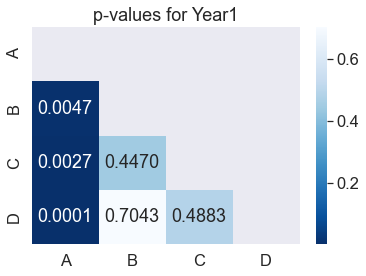

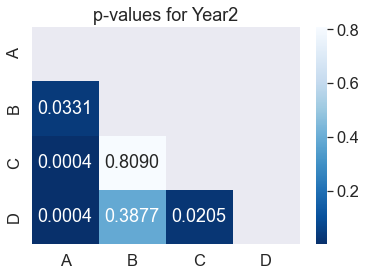

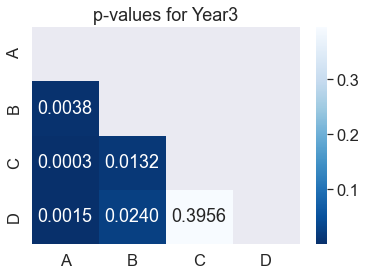

In [123]:
def combinations(year="Year1"):
    pvalues = np.zeros(shape=(4,4))
    i=0
    for genotype, genotype_df in subsample.groupby("Genotype"):
        for j, other_geno in enumerate(subsample_genotypes):
            other = subsample[subsample["Genotype"] == other_geno]
            tstat, pvalue = ttest(genotype_df[year], other[year])
            pvalues[i][j] = pvalue
        i += 1
        
    mask = np.triu(np.ones_like(pvalues, dtype=bool))
    sns.heatmap(pvalues, mask=mask, cmap="Blues_r", annot=True, fmt="0.4f", 
                xticklabels=subsample_genotypes,
                yticklabels=subsample_genotypes)
    plt.title(f"p-values for {year}")
    plt.show()
    return pvalues

array_list = []
for year in ["Year1", "Year2", "Year3"]:
    array_list.append(combinations(year))
    

### One-way ANOVA

In [55]:
def perform_oneway_anova(df, independent = "Genotype", dependent = "Year1"):
    model = ols(f'{dependent} ~ C({independent})', data=df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    sns.boxplot(data=df, y=dependent, x=independent)
    return aov_table
    
@widgets.interact(dependent=["Year1", "Year2", "Year3"])
def anova_by_year(dependent):
    return perform_oneway_anova(basic_df, independent="Genotype", dependent = dependent)
    

interactive(children=(Dropdown(description='dependent', options=('Year1', 'Year2', 'Year3'), value='Year1'), O…

### Two-way ANOVA

In [6]:
def perform_twoway_anova(df, interaction=False, ind = ["Genotype", "years"], dep = "value"):
    d_melt = pd.melt(df, id_vars=['Genotype'], value_vars=['Year1', 'Year2', 'Year3'])
    d_melt.columns = ['Genotype', 'years', 'value']
    
    if interaction: 
        model = ols(f'{dep} ~ C({ind[0]}) + C({ind[1]}) + C({ind[0]}):C({ind[1]})', data=d_melt).fit()
    else: 
        model = ols(f'{dep} ~ C({ind[0]}) + C({ind[1]})', data=d_melt).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table

@widgets.interact(interaction=[False,True])
def ineractions_twoway_anova(interaction):
    return perform_twoway_anova(basic_df, interaction)

interactive(children=(Dropdown(description='interaction', options=(False, True), value=False), Output()), _dom…

# Question 4: How do we represent data

Why does the __structure__ of data matter? 
There is a lot of math that is important to calculating statistics. 
There is not a lot we can do with words, so we need to represent them as numbers. 

There are several different types of variables that contain valuable information: 


In [13]:
basic_df

,Genotype,Year1,Year2,Year3
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95
5,B,4.02,7.20,8.94
6,C,3.99,6.09,10.02
7,C,3.30,5.88,9.63
8,C,4.41,6.51,10.38
9,D,3.75,5.19,11.40


In [61]:

def clean_lab_data(n=20):
    lab_data = pd.read_csv("data/hcvdat0.csv", index_col=0)
    lab_data = lab_data[lab_data["Category"] != "0s=suspect Blood Donor"]
    lab_data = lab_data.dropna(axis=0)
    df_list = []
    for category, category_df in lab_data.groupby("Category"):
        df_list.append(category_df.sample(12, random_state=5))
    
    return pd.concat(df_list)
        

lab_data = clean_lab_data()
print(lab_data.shape)
lab_data

(48, 13)


,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
424,0=Blood Donor,47,f,40.3,65.0,13.5,15.2,6.4,7.16,4.55,70.0,16.5,66.2
531,0=Blood Donor,65,f,33.0,74.3,13.2,16.8,4.1,7.46,5.76,52.0,9.1,64.2
362,0=Blood Donor,38,f,50.3,92.1,40.1,30.9,4.2,10.02,3.97,100.0,30.5,77.3
422,0=Blood Donor,47,f,36.4,42.0,11.1,18.3,7.2,4.97,5.47,74.0,7.9,67.0
361,0=Blood Donor,38,f,48.5,56.2,36.0,27.9,15.3,11.07,6.06,69.0,23.5,77.3
347,0=Blood Donor,35,f,62.9,51.2,20.7,23.0,2.9,6.33,4.62,67.0,15.2,71.9
275,0=Blood Donor,59,m,37.8,83.7,25.3,20.0,18.6,7.52,5.07,108.0,17.4,64.1
354,0=Blood Donor,36,f,39.7,52.0,39.9,33.5,2.9,9.00,4.18,77.0,27.0,78.5
308,0=Blood Donor,67,m,44.8,72.8,39.4,28.4,23.3,7.84,7.02,97.0,78.3,67.5
532,0=Blood Donor,68,f,41.4,102.3,38.4,26.4,6.8,8.50,6.79,59.0,23.8,68.9


albumin| (ALB)

alkaline phosphatase (ALP)

alanine amino-transferase (ALT)

aspartate amino-transferase (AST)

bilirubin (BIL) 

choline esterase (CHE)

cholesterol (CHOL)

creatinine (CREA)* 

γ-glutamyl-transferase (GGT)

total protein (PROT)*

\* I think

# Question 5: ANOVA assumptions

In [59]:
@widgets.interact(feature = ["ALB", "ALP", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"])
def show_hist_gg_plots(feature = "ALB"):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
    sns.histplot(data=lab_data, x=feature, hue="Category", stat="probability", kde=True, ax=ax1)
    qqplot(lab_data[feature].dropna(), norm, fit=True, line="45", ax=ax2)
    plt.show()
    return perform_oneway_anova(lab_data, independent = "Category", dependent = feature)


interactive(children=(Dropdown(description='feature', options=('ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL…

### Optional: Looking forward to linear models